### Подключение к локальной демо базе данных с авиаперевозками PostgreSQL
https://postgrespro.ru/education/demodb

In [112]:
import psycopg2
import pandas as pd
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn = psycopg2.connect(dbname = 'demo', user='postgres', 
                        password='1234', host='localhost')

In [3]:
cursor = conn.cursor()

### Загружаем в датафрейм данные о всех полетах, пассажирах и бронированиях

In [4]:
query = """ SELECT * FROM tickets
                INNER JOIN ticket_flights USING(ticket_no) 
                INNER JOIN flights USING(flight_id) """

In [5]:
df = pd.read_sql_query(query, con = conn)

In [6]:
df.head()

,flight_id,ticket_no,book_ref,passenger_id,passenger_name,contact_data,fare_conditions,amount,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival
0,30625,0005435212374,B3E42B,7439 263605,VERONIKA TARASOVA,{'phone': '+70372550663'},Comfort,23900.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00
1,30625,0005435212367,949E48,4819 398643,ELIZAVETA KOROLEVA,{'phone': '+70609911759'},Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00
2,30625,0005435212340,DC74E3,4757 279063,LIDIYA ABRAMOVA,{'phone': '+70218535523'},Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00
3,30625,0005435212379,8E9373,7200 541610,ALEKSANDR MAKSIMOV,{'phone': '+70122043275'},Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00
4,30625,0005435212396,959F20,8679 727676,KRISTINA YAKOVLEVA,"{'email': 'k.yakovleva-1973@postgrespro.ru', '...",Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00


In [7]:
df.shape

(1045726, 17)

In [8]:
# за какой период информация в базе данных 
print(df['scheduled_departure'].dt.date.min())
print(df['scheduled_departure'].dt.date.max())

2017-07-15
2017-09-14


In [9]:
# проверяем нулевые значения
df.isnull().sum()

flight_id                   0
ticket_no                   0
book_ref                    0
passenger_id                0
passenger_name              0
contact_data                0
fare_conditions             0
amount                      0
flight_no                   0
scheduled_departure         0
scheduled_arrival           0
departure_airport           0
arrival_airport             0
status                      0
aircraft_code               0
actual_departure       468621
actual_arrival         470896
dtype: int64

In [12]:
# нулевые значения встречаются по полетам, которые еще не завершились, задержаны или только запланированы
df[df.actual_arrival.isnull()].groupby('status')['flight_id'].count()

status
Delayed        1428
Departed       2275
On Time       20828
Scheduled    446365
Name: flight_id, dtype: int64

In [13]:
# по нескольким полетам в августе фактическое время вылета и прибытия не было заполнено, хотя статус полета был "on time" 
df[(df.actual_arrival.isnull()) & (df.status=='On Time')]['scheduled_departure'].dt.date.unique()

array([datetime.date(2017, 8, 15), datetime.date(2017, 8, 16)],
      dtype=object)

In [18]:
# для этих полетов заполним фактическое время значением из столбцов с запланированным временем
df.actual_departure = np.where((df.actual_departure.isnull()) & (df.status=='On Time'), df.scheduled_departure,  
                               df.actual_departure)

df.actual_arrival = np.where((df.actual_arrival.isnull()) & (df.status=='On Time'), df.scheduled_arrival, 
                             df.actual_arrival)

In [20]:
# повторная проверка
df[df.actual_arrival.isnull()].groupby('status')['flight_id'].count()

status
Delayed        1428
Departed       2275
Scheduled    446365
Name: flight_id, dtype: int64

### Анализ пассижиров и билетов по классам комфорта

In [24]:
# количество купленных билетов и кол-во уникальных пассажиров по классам
df.groupby(by ='fare_conditions', as_index=False) \
        .agg({'ticket_no': 'count', 'passenger_id': 'nunique'}) \
        .sort_values('ticket_no', ascending=False)

,fare_conditions,ticket_no,passenger_id
2,Economy,920793,359720
0,Business,107642,93386
1,Comfort,17291,16308


In [25]:
# как часто пассижиры, которые используют бизнес-класс, используют другие тарифы
businessPassengersID = set(df.passenger_id[df.fare_conditions=='Business'])
passBusiness = df[df.passenger_id.isin(businessPassengersID)] \
    .groupby(by ='fare_conditions', as_index=False) \
    .agg({'ticket_no': 'count', 'passenger_id': 'nunique'}) \
    .sort_values('ticket_no', ascending=False)
passBusiness

,fare_conditions,ticket_no,passenger_id
2,Economy,196925,87406
0,Business,107642,93386
1,Comfort,2708,2608


In [27]:
# как часто пассижиры, которые используют комфорт, используют другие тарифы
comfortPassengersID = set(df.passenger_id[df.fare_conditions=='Comfort'])
passComfort = df[df.passenger_id.isin(comfortPassengersID)] \
    .groupby(by ='fare_conditions', as_index=False) \
    .agg({'ticket_no': 'count', 'passenger_id': 'nunique'}) \
    .sort_values('ticket_no', ascending=False)
passComfort

,fare_conditions,ticket_no,passenger_id
2,Economy,27441,14532
1,Comfort,17291,16308
0,Business,2832,2608


In [28]:
economyPassengersID = set(df.passenger_id[df.fare_conditions=='Economy'])

In [76]:
all_types = economyPassengersID.intersection(comfortPassengersID, businessPassengersID)
dict = {k: 'all_types' for k in all_types}

In [77]:
economyAndComfort = economyPassengersID.intersection(comfortPassengersID) - all_types
dict2 = {k: 'economyAndComfort' for k in economyAndComfort}

In [80]:
economyAndBusiness = economyPassengersID.intersection(businessPassengersID) - all_types
dict3 = {k: 'economyAndBusiness' for k in economyAndBusiness}

In [81]:
businessAndComfort = comfortPassengersID.intersection(businessPassengersID) - all_types
dict4 = {k: 'businessAndComfort' for k in businessAndComfort}

In [82]:
onlyComfort = comfortPassengersID - all_types - economyAndComfort - businessAndComfort
dict5 = {k: 'onlyComfort' for k in onlyComfort}

In [83]:
onlyBusiness = businessPassengersID - all_types - businessAndComfort - economyAndBusiness
dict6 = {k: 'onlyBusiness' for k in onlyBusiness}

In [84]:
onlyEconomy = economyPassengersID - all_types - economyAndBusiness - economyAndComfort
dict7 = {k: 'onlyEconomy' for k in onlyEconomy}

In [87]:
# создаем общий словарь с категорией пассижира и его ID
dictType = {**dict, **dict2, **dict3, **dict4, **dict5, **dict6, **dict7}

In [88]:
# проверяем, что все ID пассажиров, распределились по категориям
len(all_types.union(economyAndComfort, economyAndBusiness, businessAndComfort, onlyComfort, onlyBusiness, onlyEconomy)) == \
df.passenger_id.nunique()

True

In [92]:
# определяем категорию пассажира в зависимости от того какими тарифами он пользовался
df['passenger_type'] = df.passenger_id.map(dictType)
df.head()

,flight_id,ticket_no,book_ref,passenger_id,passenger_name,contact_data,fare_conditions,amount,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival,passenger_type
0,30625,0005435212374,B3E42B,7439 263605,VERONIKA TARASOVA,{'phone': '+70372550663'},Comfort,23900.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,economyAndComfort
1,30625,0005435212367,949E48,4819 398643,ELIZAVETA KOROLEVA,{'phone': '+70609911759'},Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,onlyEconomy
2,30625,0005435212340,DC74E3,4757 279063,LIDIYA ABRAMOVA,{'phone': '+70218535523'},Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,onlyEconomy
3,30625,0005435212379,8E9373,7200 541610,ALEKSANDR MAKSIMOV,{'phone': '+70122043275'},Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,onlyEconomy
4,30625,0005435212396,959F20,8679 727676,KRISTINA YAKOVLEVA,"{'email': 'k.yakovleva-1973@postgrespro.ru', '...",Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,onlyEconomy


In [159]:
flights_by_pass = df.groupby(by=['passenger_type', 'passenger_id'], as_index=False)['ticket_no'].count() \
                    .sort_values('ticket_no')

In [153]:
# количество пассажиров, сгруппированных по кол-ву совершенных полетов и категории
flights_by_types = flights_by_pass.groupby(by=['passenger_type', 'ticket_no'], as_index=False)['passenger_id'].count()
flights_by_types.head()

,passenger_type,ticket_no,passenger_id
0,all_types,4,1677
1,all_types,6,188
2,businessAndComfort,2,730
3,businessAndComfort,4,13
4,economyAndBusiness,2,29827


Text(0.5, 1.0, 'Количество пассажиров по кол-ву совершенных полетов и категории')

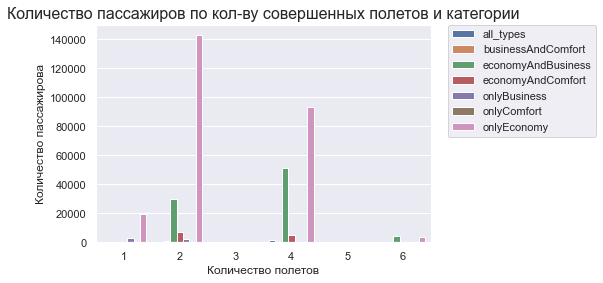

In [160]:
sns.set(style="darkgrid")
ax = sns.barplot(x='ticket_no', y='passenger_id', hue='passenger_type', data=flights_by_types)
ax.set(xlabel='Количество полетов', ylabel='Количество пассажирова')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Количество пассажиров по кол-ву совершенных полетов и категории', fontsize = 16)

### Зависимость стоимости билетов и длительности полета

In [176]:
# добавляем столбец со временем полета
df['flight_time'] = (df.scheduled_arrival - df.scheduled_departure) / pd.Timedelta(minutes=1)
df.head()

,flight_id,ticket_no,book_ref,passenger_id,passenger_name,contact_data,fare_conditions,amount,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival,passenger_type,flight_time
0,30625,0005435212374,B3E42B,7439 263605,VERONIKA TARASOVA,{'phone': '+70372550663'},Comfort,23900.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,economyAndComfort,105.0
1,30625,0005435212367,949E48,4819 398643,ELIZAVETA KOROLEVA,{'phone': '+70609911759'},Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,onlyEconomy,105.0
2,30625,0005435212340,DC74E3,4757 279063,LIDIYA ABRAMOVA,{'phone': '+70218535523'},Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,onlyEconomy,105.0
3,30625,0005435212379,8E9373,7200 541610,ALEKSANDR MAKSIMOV,{'phone': '+70122043275'},Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,onlyEconomy,105.0
4,30625,0005435212396,959F20,8679 727676,KRISTINA YAKOVLEVA,"{'email': 'k.yakovleva-1973@postgrespro.ru', '...",Economy,14000.0,PG0013,2017-07-16 15:15:00+00:00,2017-07-16 17:00:00+00:00,AER,SVO,Arrived,773,2017-07-16 15:18:00+00:00,2017-07-16 17:04:00+00:00,onlyEconomy,105.0


In [181]:
# economy class
economy = df[df['fare_conditions']=='Economy']

Text(0.5, 1.0, 'Зависимость длительности полета и его стоимости в эконом классе')

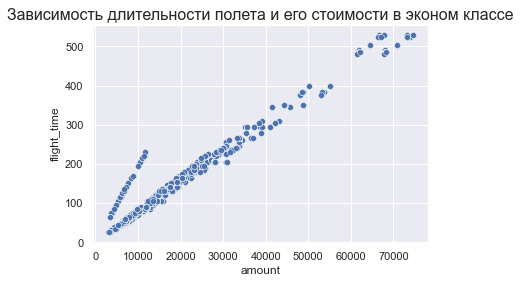

In [180]:
sns.scatterplot(x='amount', y='flight_time', data=economy)
plt.title('Зависимость длительности полета и его стоимости в классе economy', fontsize=16)

In [182]:
# comfort class
comfort = df[df['fare_conditions']=='Comfort']

Text(0.5, 1.0, 'Зависимость длительности полета и его стоимости в классе comfort')

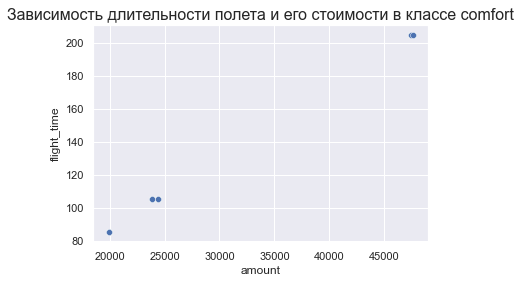

In [183]:
sns.scatterplot(x='amount', y='flight_time', data=comfort)
plt.title('Зависимость длительности полета и его стоимости в классе comfort', fontsize=16)

### Статусы рейсов

In [161]:
by_status = df.groupby('status', as_index=False)['ticket_no'].count().sort_values('ticket_no', ascending=False)

Text(0.5, 1.0, 'Количество рейсов по статусу')

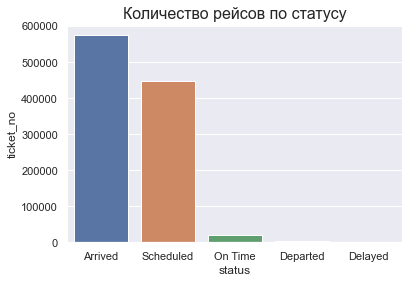

In [163]:
sns.barplot(x='status',y='ticket_no', data=by_status)
plt.title('Количество рейсов по статусу', fontsize = 16)

In [58]:
df[df.status=='Scheduled']['scheduled_departure'].dt.date.unique()

array([datetime.date(2017, 8, 16), datetime.date(2017, 8, 17),
       datetime.date(2017, 8, 18), datetime.date(2017, 8, 19),
       datetime.date(2017, 8, 20), datetime.date(2017, 8, 21),
       datetime.date(2017, 8, 22), datetime.date(2017, 8, 23),
       datetime.date(2017, 8, 24), datetime.date(2017, 8, 25),
       datetime.date(2017, 8, 26), datetime.date(2017, 8, 27),
       datetime.date(2017, 8, 28), datetime.date(2017, 8, 29),
       datetime.date(2017, 8, 30), datetime.date(2017, 8, 31),
       datetime.date(2017, 9, 1), datetime.date(2017, 9, 2),
       datetime.date(2017, 9, 3), datetime.date(2017, 9, 4),
       datetime.date(2017, 9, 5), datetime.date(2017, 9, 6),
       datetime.date(2017, 9, 7), datetime.date(2017, 9, 8),
       datetime.date(2017, 9, 9), datetime.date(2017, 9, 10),
       datetime.date(2017, 9, 11), datetime.date(2017, 9, 12),
       datetime.date(2017, 9, 13), datetime.date(2017, 9, 14)],
      dtype=object)